In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import time
from matplotlib.animation import FuncAnimation
import time

class SpectrumEnvironment:
    def __init__(self, num_bands=10, steps=25,detection_method="energy_detection"):
        self.num_bands = num_bands  # Total number of frequency bands
        self.steps = steps
        self.channel_states = [[] for _ in range(num_bands)]
        self.transition_matrices = self._initialize_transition_matrices()
        self.state = self._generate_spectrum_state()  # Current state of the spectrum
        self.total_reward = 0  # Track total reward
        self.rewards = []  # Track rewards for each step
        self.energy_costs = [[] for _ in range(num_bands)]
        self.total_energy = 0
        valid_methods = ["energy_detection", "matched_filter", "cyclostationary"]
        if detection_method not in valid_methods:
            raise ValueError(f"Invalid detection method. Choose from {valid_methods}")
        self.detection_method = detection_method
    
    def _initialize_transition_matrices(self):
        """
        Generate a unique random Markov chain transition matrix for each band.
        Each matrix ensures that the probabilities in each row sum to 1.
        """
        matrices = []
        for _ in range(self.num_bands):
            # Generate a random 2x2 matrix
            random_matrix = np.random.rand(2, 2)
            # Normalize each row to sum to 1
            transition_matrix = random_matrix / random_matrix.sum(axis=1, keepdims=True)
            matrices.append(transition_matrix)
        return matrices

    def _generate_spectrum_state(self):
        """
        Generate a spectrum state using Markov chain dynamics for each band.
        Each band has a distinct transition matrix and evolves over 'steps' timesteps.
        """
        new_states = []

        for band in range(self.num_bands):
            # Get the last state or default to 0 if no history exists
            last_state = self.channel_states[band][-1] if self.channel_states[band] else 0

            # Generate states for the next 'steps' timesteps using the Markov chain
            band_states = []
            for _ in range(self.steps):
                # Determine the next state based on the Markov chain
                transition_probabilities = self.transition_matrices[band][last_state]
                next_state = np.random.choice([0, 1], p=transition_probabilities)
                band_states.append(next_state)
                last_state = next_state  # Update for the next step

            # Append the generated states to history
            self.channel_states[band] = band_states
        return self.channel_states
    
    def energy_detection(self, time_step, band, delta=0.1):
        """
        Perform energy detection for a specific band and timestep.
        Calculates energy dynamically and assigns rewards based on the state and energy detection.

        Parameters:
        - time_step (int): The timestep to evaluate.
        - band (int): The band (channel) number to evaluate.
        - delta (float): The change in energy state for transitions (default: 0.1).

        Returns:
        - reward (int): The reward calculated based on energy detection and the channel state.
        """
        # Ensure the inputs are within valid ranges
        if not (0 <= band < self.num_bands):
            raise ValueError("Band number out of range.")
        if not (0 <= time_step < self.steps):
            raise ValueError("Time step out of range.")

        # Current state of the channel
        current_state = self.channel_states[band][time_step]

        # Retrieve previous energy state (default to 0 if no previous energy state)
        previous_energy = self.energy_costs[band][-1] if len(self.energy_costs[band]) > 0  else 0

        # Calculate new energy state
        if current_state == 1:
            # Increase energy by delta if the state is 1
            new_energy = previous_energy + delta
        else:
            # No change in energy if the state is 0
            new_energy = previous_energy

        self.energy_costs[band].append(new_energy)
        return new_energy

    def matched_filter_fft(self,time_step,band):
        """
        Simulates matched filter detection using FFT with adaptive energy consumption.
        Energy consumption is higher for detecting occupied states (state = 1).
        
        Parameters:
        - band (int): The band (channel) to evaluate.
        - time_step (int): The time step for the evaluation.

        Returns:
        - energy_consumption (float): The energy consumed by the matched filter detection.
        """
        # Ensure inputs are valid
        if not (0 <= band < self.num_bands):
            raise ValueError("Band number out of range.")
        if not (0 <= time_step < self.steps):
            raise ValueError("Time step out of range.")

        # Current state of the channel
        current_state = self.channel_states[band][time_step]
        # Base energy consumption for matched filter detection
        base_energy = 0.2
        # Additional energy cost based on the state (higher for state = 1)
        state_energy = 0.1 if current_state == 1 else 0.05

        # Add an energy cost for history length as in a Markov process
        sensing_history_length = len(self.energy_costs[band])
        if sensing_history_length > 0:
            history_energy = 0.02 + self.energy_costs[band][-1]
        else:
            history_energy = 0.02

        # Total energy consumption
        total_energy_consumption = base_energy + state_energy + history_energy
        # Update energy costs history for this band
        self.energy_costs[band].append(total_energy_consumption)

        return total_energy_consumption


    def cyclostationary_detection(self,time_step,band):
        """
        Simulates cyclostationary feature detection based on periodic properties.
        Energy consumption is moderate and depends on the band state and history.
        
        Parameters:
        - band (int): The band (channel) to evaluate.
        - time_step (int): The time step for the evaluation.

        Returns:
        - energy_consumption (float): The energy consumed by cyclostationary detection.
        """
        # Ensure inputs are valid
        if not (0 <= band < self.num_bands):
            raise ValueError("Band number out of range.")
        if not (0 <= time_step < self.steps):
            raise ValueError("Time step out of range.")

        # Current state of the channel
        current_state = self.channel_states[band][time_step]

        # Base energy consumption for cyclostationary detection
        base_energy = 0.15

        # Additional energy cost based on the state (higher for state = 1)
        state_energy = 0.07 if current_state == 1 else 0.03

        # Add an energy cost for history length as in a Markov process
        sensing_history_length = len(self.energy_costs[band])
        if sensing_history_length > 0:
            history_energy = 0.015 + self.energy_costs[band][-1]
        else:
            history_energy = 0.015

        # Total energy consumption
        total_energy_consumption = base_energy + state_energy + history_energy

        # Update energy costs history for this band
        self.energy_costs[band].append(total_energy_consumption)

        return total_energy_consumption
    
    def step(self, time_step, action):
        """
        Perform an action and compute reward based on the chosen action.
        Actions:
        - Even indices: Perform detection on band `(action // 2)`.
        - Odd indices: Skip detection on band `(action // 2)`.
        
        Returns:
        - reward (float): The reward based on the action and state.
        - next_state (tuple): The next state for the agent.
        """
        band = action // 2
        detect = action % 2 == 0  # True if detection action, False if skip action
        if not (0 <= band < self.num_bands):
            raise ValueError("Band number out of range.")
        if not (0 <= time_step < self.steps):
            raise ValueError("Time step out of range.")

        state = self.channel_states[band][time_step]
        reward = 0

        if detect:
            # Perform detection and calculate energy cost
            energy = self.detect(time_step, band)
        else:
            # Skipping detection has no energy cost but misses rewards
            energy = 0  # Penalty for skipping (can be adjusted)
            
        reward = (30 if state == 0 else -15) - energy
        self.total_reward += reward
        self.total_energy += energy
        self.rewards.append(reward)
        next_state = (time_step + 1,)
        return reward, next_state
    
    def detect(self, time_step, band):
        """
        Wrapper for the detection method.
        """
        if self.detection_method == "energy_detection":
            return self.energy_detection(time_step, band)
        elif self.detection_method == "matched_filter":
            return self.matched_filter_fft(time_step, band)
        elif self.detection_method == "cyclostationary":
            return self.cyclostationary_detection(time_step, band)
    
    def soft_reset(self):
        self.energy_costs = [[] for _ in range(self.num_bands)]
        self.total_energy = 0
        

energy_detection


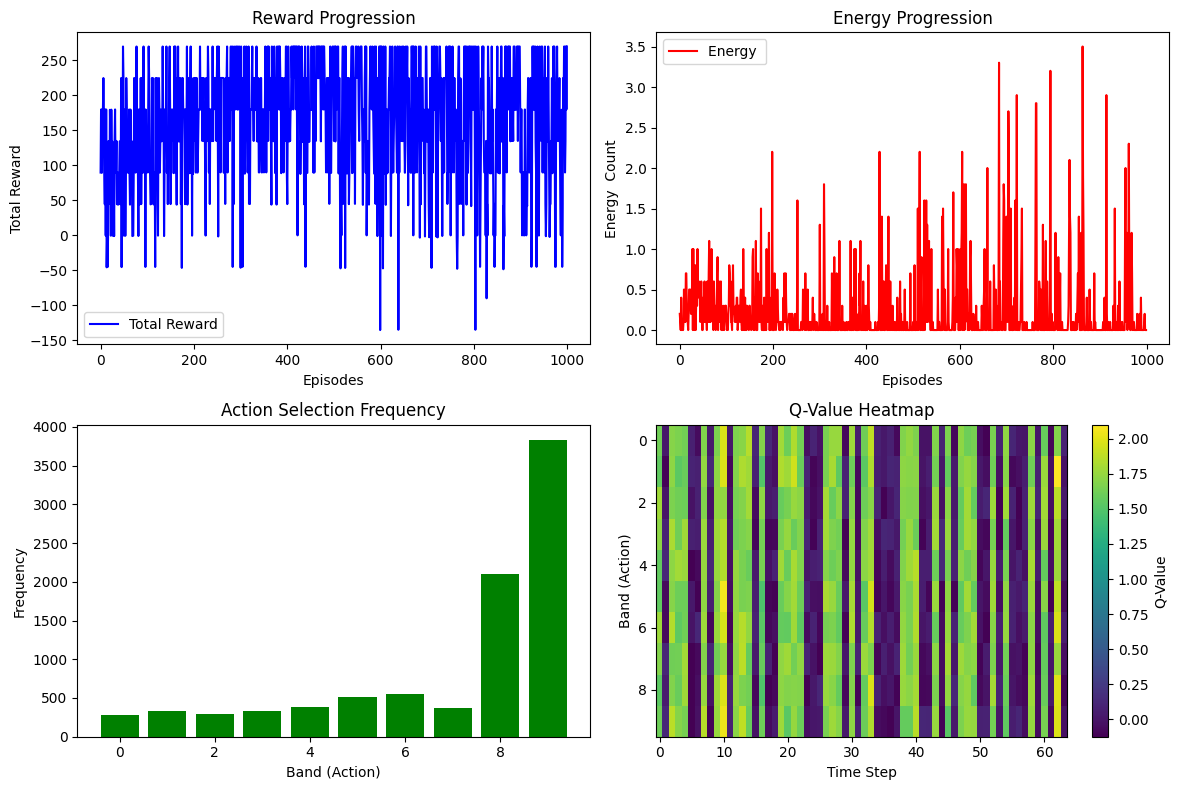

matched_filter


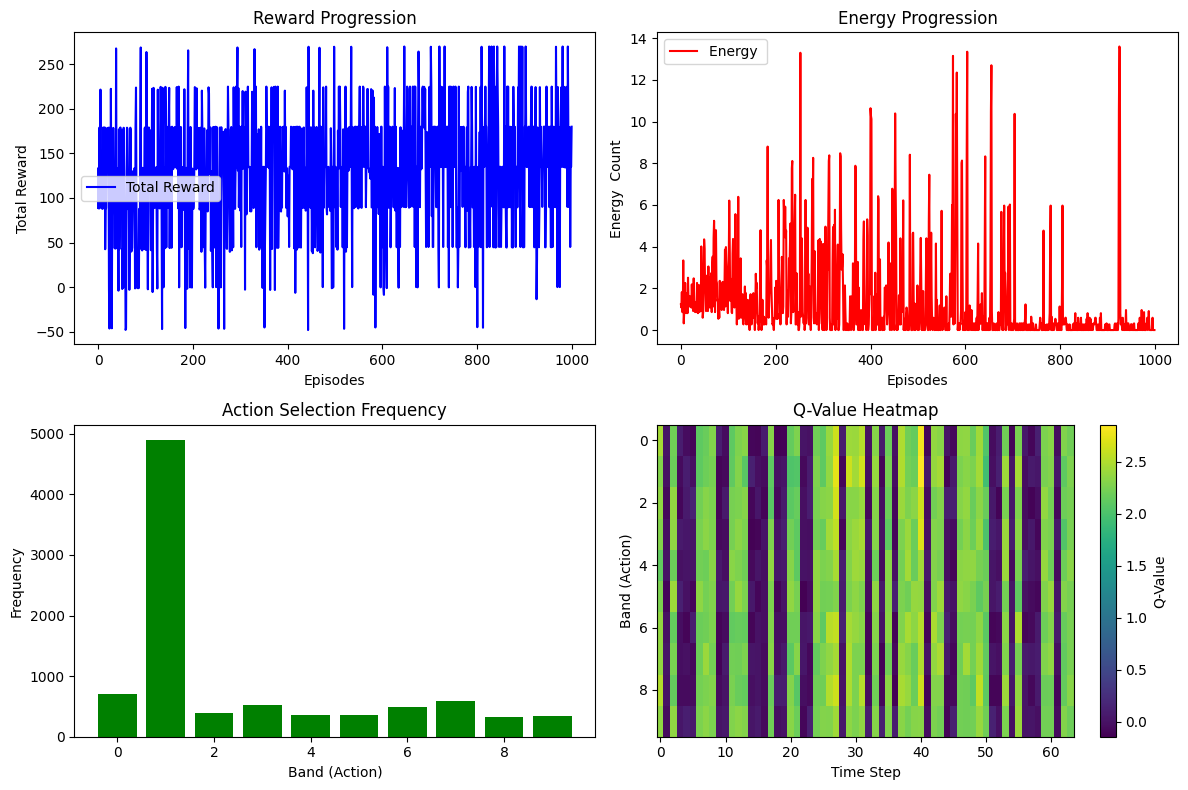

cyclostationary


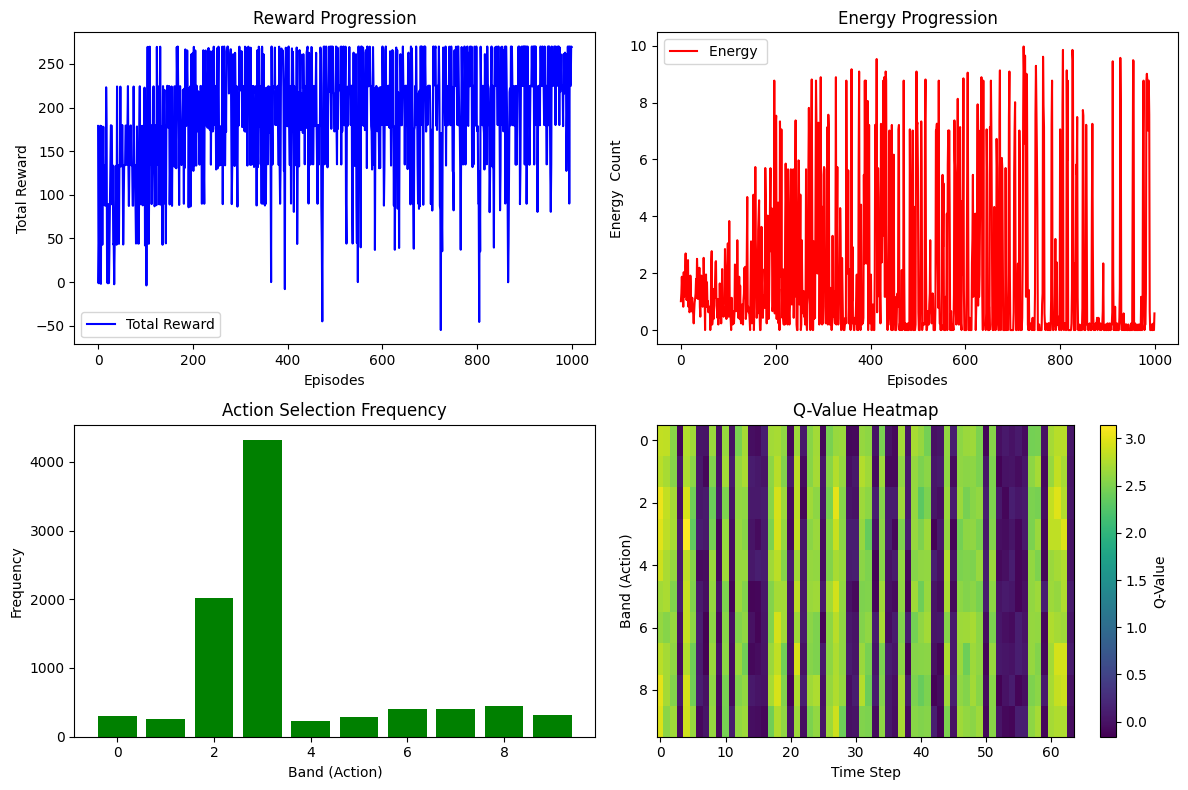

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    def __init__(self, env, alpha=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, batch_size=32, memory_size=10000):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.memory_size = memory_size

        # Input is time step; Output is 2 × num_bands (detect/skip for each band)
        self.q_network = QNetwork(input_dim=1, output_dim=2 * self.env.num_bands)
        self.target_network = QNetwork(input_dim=1, output_dim=2 * self.env.num_bands)
        self.target_network.load_state_dict(self.q_network.state_dict())

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.alpha)
        self.replay_buffer = deque(maxlen=self.memory_size)

        self.episode_rewards = []
        self.energy_detection_usage = []
        self.episode_energy = []
        self.action_counts = np.zeros(2 * self.env.num_bands)

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 2 * self.env.num_bands - 1)
        else:
            state_tensor = torch.tensor([state], dtype=torch.float32)
            q_values = self.q_network(state_tensor)
            return torch.argmax(q_values).item()
    def store_experience(self, state, action, reward, next_state):
        self.replay_buffer.append((state, action, reward, next_state))

    def sample_experience(self):
        return random.sample(self.replay_buffer, self.batch_size)

    def update_q_network(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        batch = self.sample_experience()
        states, actions, rewards, next_states = zip(*batch)

        states_tensor = torch.tensor(states, dtype=torch.float32)
        actions_tensor = torch.tensor(actions, dtype=torch.int64)
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
        next_states_tensor = torch.tensor(next_states, dtype=torch.float32)

        q_values = self.q_network(states_tensor)
        next_q_values = self.target_network(next_states_tensor)

        q_value_for_actions = q_values.gather(1, actions_tensor.view(-1, 1)).squeeze(1)
        next_q_value_for_best_action = torch.max(next_q_values, dim=1)[0]
        target_q_values = rewards_tensor + self.gamma * next_q_value_for_best_action

        loss = nn.MSELoss()(q_value_for_actions, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def train(self, episodes=500):
        for episode in range(episodes):
            self.env._generate_spectrum_state()
            self.env.soft_reset()
            total_reward = 0

            for time_step in range(self.env.steps - 1):
                state = (time_step,)
                action = self.choose_action(state)

                self.action_counts[action] += 1
                reward, next_state = self.env.step(time_step, action)

                self.store_experience(state, action, reward, next_state)
                self.update_q_network()

                total_reward += reward

            self.episode_rewards.append(total_reward)
            self.episode_energy.append(self.env.total_energy)
            self.epsilon = max(0.1, self.epsilon * self.epsilon_decay)
            self.env.soft_reset()

            if episode % 10 == 0:
                self.target_network.load_state_dict(self.q_network.state_dict())

            #print(f"Episode {episode + 1}/{episodes}: Reward = {total_reward}, Epsilon = {self.epsilon}")
    def visualize_results(self):
        episodes = len(self.episode_rewards)

        plt.figure(figsize=(12, 8))
        # Plot Total Rewards per Episode
        plt.subplot(2, 2, 1)
        plt.plot(range(episodes), self.episode_rewards, label="Total Reward", color="blue")
        plt.xlabel("Episodes")
        plt.ylabel("Total Reward")
        plt.title("Reward Progression")
        plt.legend()
        
        plt.subplot(2, 2, 2)
        plt.plot(range(episodes), self.episode_energy, label="Energy ", color="red")
        plt.xlabel("Episodes")
        plt.ylabel("Energy  Count")
        plt.title("Energy Progression")
        plt.legend()
        
        # Plot Action Selection Frequency
        plt.subplot(2, 2, 3)
        plt.bar(range(self.env.num_bands * 2), self.action_counts, color="green")
        plt.xlabel("Band (Action)")
        plt.ylabel("Frequency")
        plt.title("Action Selection Frequency")

        # Plot Q-Value Heatmap
        plt.subplot(2, 2, 4)
        q_table = self.q_network.fc3.weight.data.cpu().numpy()
        plt.imshow(q_table, aspect="auto", cmap="viridis", interpolation="nearest")
        plt.colorbar(label="Q-Value")
        plt.xlabel("Time Step")
        plt.ylabel("Band (Action)")
        plt.title("Q-Value Heatmap")

        plt.tight_layout()
        plt.show()

for i in ["energy_detection", "matched_filter", "cyclostationary"]:
    print(i)
    env = SpectrumEnvironment(num_bands=5, steps=10,detection_method=i)
    agent = DQNAgent(env)
    agent.train(episodes=1000)
    agent.visualize_results()